In [287]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy.optimize import fmin_powell
import seaborn as sns
from sklearn.linear_model import LogisticRegression

%matplotlib inline
plt.style.use('seaborn')

In [172]:
# simulate data

In [199]:
PRESIDENT_PROBABILITY = .03
ACCIDENT_PROBABILITY = .1
TRIALS = 200

In [200]:
president = np.random.binomial(n=1, p=PRESIDENT_PROBABILITY, size=TRIALS)
accident = np.random.binomial(n=1, p=ACCIDENT_PROBABILITY, size=TRIALS)

In [201]:
print( f'President Mean: {president.mean()}' )
print( f'Accident Mean: {accident.mean()}' )

President Mean: 0.035
Accident Mean: 0.12


In [202]:
traffic_probabilities = []
for president_observed, accident_observed in zip(president, accident):
    if not president_observed:
        probability = .5 if accident_observed else .1
    else:
        probability = .9 if accident_observed else .6
    traffic_probabilities.append( probability )
    
traffic = np.random.binomial(n=1, p=traffic_probabilities)

In [203]:
print( f'Traffic Mean: {traffic.mean()}')

Traffic Mean: 0.14


In [204]:
observed_data = pd.DataFrame({'president': president, 'accident': accident, 'traffic': traffic})

In [205]:
# probabilities are no longer fixed values, but distributions

In [206]:
times_president_observed = sum(president)
times_president_not_observed = len(president) - times_president_observed

president_probability_samples = np.random.beta(
    a=1 + times_president_observed, 
    b=1 + times_president_not_observed, 
    size=4567
)

In [207]:
times_accident_observed = sum(accident)
times_accident_not_observed = len(accident) - times_accident_observed

accident_probability_samples = np.random.beta(
    a=1 + times_accident_observed, 
    b=1 + times_accident_not_observed, 
    size=4567
)

In [208]:
# P(traffic | accident, president)

In [209]:
# logistic regression baseline

glm = LogisticRegression()
_ = glm.fit(X=observed_data[['president', 'accident']], y=observed_data['traffic'])

In [210]:
precision = 5
print( f'Estimated intercept: {glm.intercept_[0]:.{precision}}' )
print( f'Estimated president coefficient: {glm.coef_[0][0]:.{precision}}' )
print( f'Estimated accident coefficient: {glm.coef_[0][1]:.{precision}}' )

Estimated intercept: -2.1145
Estimated president coefficient: 1.1937
Estimated accident coefficient: 1.7263


In [211]:
with pm.Model() as model:
    pm.glm.glm('traffic ~ president + accident', observed_data, family=pm.glm.families.Binomial())
    start_MAP = pm.find_MAP(fmin=fmin_powell, disp=False)
    step = pm.NUTS(scaling=start_MAP)
    trace = pm.sample(2000, step=step, njobs=2, progressbar=True)

100%|██████████| 2000/2000 [00:07<00:00, 279.55it/s]


In [212]:
# i'm not sure why, but everything seems to go to hell when i have `njobs=4`

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x142a691d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13b321438>]], dtype=object)

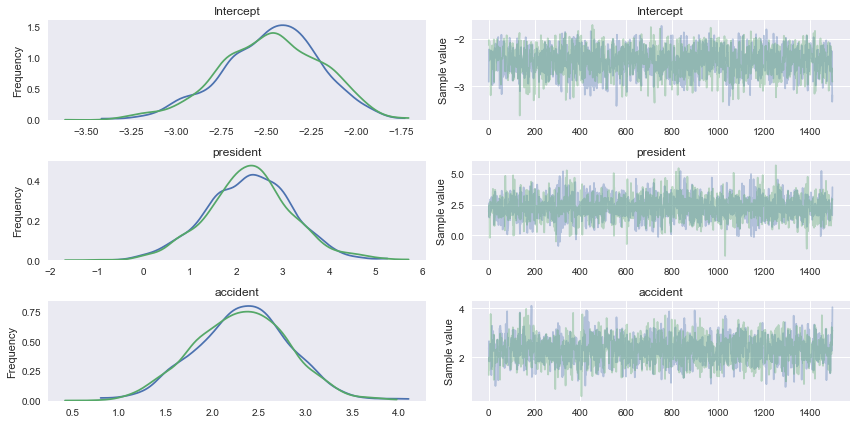

In [217]:
warmup = 500
variables = ['Intercept', 'president', 'accident']

pm.traceplot(trace[warmup:], varnames=variables)

In [228]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_counterfactual_predictions(president_value, accident_value, trace=trace):
    log_odds_p = trace['Intercept'] + trace['president']*president_value + trace['accident']*accident_value
    return sigmoid(log_odds_p)

In [292]:
president_0_accident_0_predictions = compute_counterfactual_predictions(0, 0, trace=trace)
president_0_accident_1_predictions = compute_counterfactual_predictions(0, 1, trace=trace)
president_1_accident_0_predictions = compute_counterfactual_predictions(1, 0, trace=trace)
president_1_accident_1_predictions = compute_counterfactual_predictions(1, 1, trace=trace)

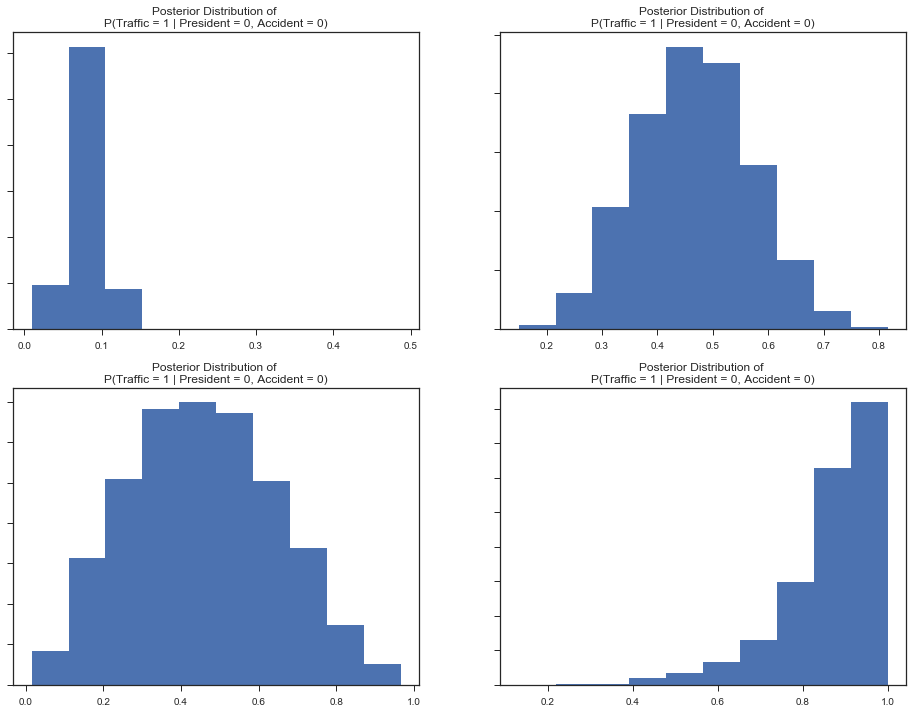

In [332]:
plt.figure(figsize=(16, 12))

subplot = plt.subplot(221)
plt.setp(subplot.get_yticklabels(), visible=False)
plt.hist(president_0_accident_0_predictions)
plt.title('Posterior Distribution of \nP(Traffic = 1 | President = 0, Accident = 0)')

subplot = plt.subplot(222)
plt.setp(subplot.get_yticklabels(), visible=False)
_ = plt.hist(president_0_accident_1_predictions)
plt.title('Posterior Distribution of \nP(Traffic = 1 | President = 0, Accident = 0)')

subplot = plt.subplot(223)
plt.setp(subplot.get_yticklabels(), visible=False)
_ = plt.hist(president_1_accident_0_predictions)
plt.title('Posterior Distribution of \nP(Traffic = 1 | President = 0, Accident = 0)')

subplot = plt.subplot(224)
plt.setp(subplot.get_yticklabels(), visible=False)
_ = plt.hist(president_1_accident_1_predictions)
plt.title('Posterior Distribution of \nP(Traffic = 1 | President = 0, Accident = 0)')